In [1]:
import os
import sys
import subprocess
root = "/data/luojaa/eukgen/"
%cd {root}
sys.path.append(root)
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import plotly.graph_objects as go
#import altair_saver

import ete3
from ete3 import Tree, TreeStyle, TextFace

from core_functions.microcosm_functions import color_tree, tree_analysis
from core_functions.altair_plots import plot_alignment, plot_cumsum_counts
from core_functions.tree_functions import get_outlier_nodes_by_lognorm

#disable altair max rows
alt.data_transformers.disable_max_rows()
#get default altair style'
%run /data/luojaa/eukgen/styling_and_visualisation.py

#dont wrap text output from cells
from IPython.core.display import display, HTML
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

/vf/users/luojaa/eukgen


/tmp/ipykernel_1040028/1593980000.py:26: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
os.environ['QT_QPA_PLATFORM']='offscreen'

### read in microcosm_dl files

In [3]:
ec_koginfo = pd.read_csv("/data/luojaa/kegg_stats/KOG_merged.tsv", sep = "\t")
ec_koginfo["EC_single"] = ec_koginfo["EC"].apply(lambda x: x.split("|"))
ec_koginfo = ec_koginfo.explode("EC_single")
ec_2kog = ec_koginfo[ec_koginfo.EC_single != "none" ].loc[:,["kogid", "name", "EC_single"]]
ec_2kogs = ec_2kog.groupby("EC_single")["kogid"].apply(lambda x: "|".join(set(x))).reset_index().rename(columns={"EC_single":"EC","kogid":"KOGS"})

ec_2kog_dict = ec_2kog.drop("name", axis = 1).set_index("kogid").to_dict()["EC_single"]
ec_kogs = set(ec_2kog[~ec_2kog.EC_single.str.contains("-")].kogid)

In [4]:
#tree_data_dl_old = pd.read_csv("/data/luojaa/eukgen/microcosm_dl_new_tree_data.tsv", sep = "\t").dropna()
tree_data_dl = pd.read_csv("/data/luojaa/eukgen/microcosm_dl_minHGT_tree_data.tsv", sep = "\t").dropna()
tree_data_dl["EC"] = tree_data_dl.tree_name.apply(lambda x: x.split("_")[0])
dl_annot = pd.read_csv("/data/luojaa/eukgen/microcosm/repseq.microcosms.tmp.tsv", sep = "\t").drop("domain", axis = 1).rename(columns = {"Query":"euk_clade_rep"})

ec_descriptions = pd.read_csv("/data/luojaa/microcosm_metadata/brenda_ec_mappings.tsv", sep = "\t")
ec_info = pd.merge(ec_2kogs, ec_descriptions, on="EC", how="right").drop("comments", axis=1)
tree_data_dl_mapped = pd.merge(tree_data_dl, dl_annot, on=["euk_clade_rep", "EC"], how="left")
tree_data_dl_mapped = pd.merge(tree_data_dl_mapped, ec_info, on="EC", how="left")
tree_data_dl_mapped.fillna("None", inplace=True)
tree_data_dl_mapped = tree_data_dl_mapped.set_index("tree_name")

/tmp/ipykernel_1040028/2065541710.py:2: DtypeWarning: Columns (3,4,7,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  tree_data_dl = pd.read_csv("/data/luojaa/eukgen/microcosm_dl_minHGT_tree_data.tsv", sep = "\t").dropna()


In [5]:
#leaf_mapping_dl_old = pd.read_csv("/data/luojaa/eukgen/microcosm_dl_tree_data.leaf_mapping.tsv", sep = "\t")
#leaf_mapping_dl = pd.read_csv("/data/luojaa/eukgen/microcosm_dl_final_tree_data.leaf_mapping.tsv", sep = "\t")

### read in microcosm files

In [97]:
tree_data = pd.read_csv("/data/luojaa/eukgen/microcosm_minHGT_tree_data.tsv", sep = "\t").set_index("tree_name")

/tmp/ipykernel_1040028/2838612536.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  tree_data = pd.read_csv("/data/luojaa/eukgen/microcosm_minHGT_tree_data.tsv", sep = "\t").set_index("tree_name")


In [99]:
# not all microcosms are annotated, and not all annotated clusters made it to microcosms
kegg_annot = pd.read_csv("/data/tobiassonva/data/eukgen/processing/euk72_ep/euk72_ep.KEGG_annotation.swapped_names.tsv", sep = "\t")
annotated_clusters = set(kegg_annot.Query)
tree_data_annot = tree_data[tree_data.index.isin(annotated_clusters)].reset_index()

In [100]:
# map KOG annotations and EC annotations to tree data
tree_data_annot_tmp = tree_data_annot.set_index("tree_name")
kegg_annot_tmp = kegg_annot.set_index("Query")[["Target", "Score", "Description", "Pairwise_cov"]]
tree_data_mapped = pd.merge(tree_data_annot_tmp, kegg_annot_tmp, left_index= True, right_index= True, how= "left")#.drop("Unnamed: 0", axis = 1)
tree_data_mapped_tmp = tree_data_mapped.reset_index().set_index("Target")
ec_2kog_tmp = ec_2kog.set_index("kogid")
tree_data_mapped = pd.merge(tree_data_mapped_tmp, ec_2kog_tmp, how = "left", left_index = True, right_index = True).reset_index().fillna("None").rename(columns={"EC_single":"EC"}).set_index("tree_name")
tree_data_tophits = tree_data_mapped.sort_values(["euk_clade_rep", "Score"], ascending = False).drop_duplicates(["euk_clade_rep", "prok_clade_rep"])

### other data

In [10]:
# read in the kegg maps and modules
kog_functions = pd.read_csv('/data/luojaa/uid_stats/kog_functions.tsv', sep = '\t').drop_duplicates("KOGID")
category_data = pd.read_csv('/data/luojaa/kegg_stats/kegg_categories.tsv', sep = '\t')
category_data = pd.merge(category_data, kog_functions, on = "KOGID", how = "outer").dropna()
module_data = category_data[category_data["CATEGORY_ID"].str.startswith("M")]
pathway_data = category_data[category_data["CATEGORY_ID"].str.contains("map")]


In [11]:
# read in BRITE data
kog_brite = pd.read_csv("/data/luojaa/kegg_stats/KOG_merged.tsv", sep = "\t")
brite_desc = pd.read_csv("/data/tobiassonva/data/databases/kegg/kegg_metadata/KOG_brite_map.tsv", dtype=str, sep = "\t").set_index("brite_id")
kogs_w_pathway = set(pathway_data.KOGID)
kog_brite_nomap = kog_brite[~kog_brite.kogid.isin(kogs_w_pathway)].reset_index()
kog_brite_nomap["brite"] = kog_brite_nomap.brite_C.apply(lambda x: x.split("|"))
kog_brite_nomap = kog_brite_nomap.explode("brite").reset_index()

In [12]:
brite_counts = kog_brite.brite_C.apply(lambda x: x.split("|")).explode().value_counts()
brite_nomap_counts = kog_brite_nomap.brite.value_counts()
brite_nomap_fraction = pd.merge(brite_counts,brite_nomap_counts, how = "right", left_index=True, right_index=True)
brite_nomap_fraction["fraction_missing"] = brite_nomap_fraction.count_y / brite_nomap_fraction.count_x
brite_nomap_fraction = pd.merge(brite_nomap_fraction, brite_desc, how = "left", left_index=True, right_index=True)

# eval microcosms

In [15]:
# sandbox, universal genes
kogs = set(kog_brite[(kog_brite.brite_C.str.contains("03400")) & ~(kog_brite.kogid.isin(kogs_w_pathway))].kogid)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(kogs)]
trees_filtered = tree_data_important[(tree_data_important["Target"].isin(kogs))]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.5,1)]
systems = iter(trees_cELW.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))

NameError: name 'tree_data_important' is not defined

In [ ]:
a = set(kogs).difference(set(tree_data_mapped.Target))
b = set(kogs).difference(set(trees_filtered.Target))
c = b.difference(a)
len(set(kogs)), len(set(trees_filtered.Target)), len(b), len(a), len(set(trees_cELW.Target))

In [ ]:
# central metabolism
kogs = set(kog_brite[(kog_brite.brite_A == "09100")].kogid)
trees_filtered = tree_data_mapped[tree_data_mapped.Target.str.contains("|".join(kogs))]
trees_topscore = trees_filtered.sort_values(["Score"], ascending = False).drop_duplicates(["euk_clade_rep", "c-ELW"]).sort_values(["tree_name"])
trees_cELW = trees_topscore[trees_topscore["c-ELW"].between(.5,.999)]
#cELW_freq = trees_cELW.groupby("prok_taxa")["c-ELW"].sum() / sum(trees_cELW.groupby("prok_taxa")["c-ELW"].sum())


trees_dl_filtered = tree_data_dl_mapped[tree_data_dl_mapped.KOGS.str.contains("|".join(kogs))]
trees_dl_tophit = trees_dl_filtered.sort_values(["c-ELW"], ascending = False).drop_duplicates("euk_clade_rep").sort_values(["tree_name"])
trees_dl_cELW = trees_dl_filtered[trees_dl_filtered["c-ELW"].between(.5,.999)]
#cELW_dl_freq = trees_dl_cELW.groupby("prok_taxa")["c-ELW"].sum() / sum(trees_dl_cELW.groupby("prok_taxa")["c-ELW"].sum())


In [ ]:
# sandbox, microcosms_dl
#kogs_dl = set(module_data[module_data.CATEGORY_ID == "M00038"].KOGID) # glycolysis
#kogs_dl = set(kog_brite[(kog_brite.brite_C.str.contains("02000"))].kogid)
kogs_dl = set(kog_brite[(kog_brite.brite_B.str.contains("09101"))].kogid)

trees_dl_filtered = tree_data_dl_mapped[tree_data_dl_mapped.KOGS.str.contains("|".join(kogs_dl))].sort_values("KOG")
trees_dl_cELW = trees_dl_filtered[trees_dl_filtered["c-ELW"].between(.5,1)]
systems = iter(trees_dl_filtered.index.unique())
print(len(set(trees_dl_filtered.index)), len(set(trees_dl_cELW.index)))
microcosm_path = '/data/luojaa/eukgen/processing/microcosm_dl/'

In [ ]:
# # translocases
# tree_translocases_dl = tree_data_dl_mapped[tree_data_dl_mapped.index.str.slice(start=0,stop=1) == "7"]
# tree_translocases_dl["KOG"] = tree_translocases_dl.KOGS.apply(lambda x: x.split("|"))
# tree_translocases_dl_explode = tree_translocases_dl.explode("KOG")
# trees_translocases_dl_cELW = tree_translocases_dl_explode[tree_translocases_dl_explode["c-ELW"].between(.5,1)]
# print(len(set(tree_translocases_dl_explode.index)), len(set(trees_translocases_dl_cELW.index)))
# systems = iter(trees_translocases_dl_cELW.index.unique())

In [ ]:
# central carbon
trees_filtered = tree_data_tophits[(tree_data_tophits["Target"] == "K00948")] # PRPS 
trees_filtered = tree_data_tophits[(tree_data_tophits["Target"] == "K01803")] # TPI
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.5,1)]
systems = iter(trees_filtered.index)


In [ ]:
# # central carbon
# trees_filtered = tree_data_tophit[(tree_data_tophit["Description"].str.contains("fructose-bisphosphate aldolase"))]
# trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.5,1)]
# systems = iter(trees_cELW.tree_name)


In [ ]:
kogs_ccm = set(kog_brite[(kog_brite.brite_B.str.contains("09101"))].kogid) #carb metabolism
trees_cELW_ccm = trees_cELW_c[trees_cELW_c["Target"].isin(kogs_ccm)]
trees_cELW_dl_ccm = trees_cELW_dl_c[trees_cELW_dl_c["KOGS"].str.contains("|".join(kogs_ccm))]

In [ ]:
# compute cELW fractions to isolate largely asgard ECs
trees_cELW_frac = trees_cELW_ccm.groupby(["prok_taxa", "EC"])["c-ELW"].sum().reset_index()
celw_frac = []
for i in range(len(trees_cELW_frac)):
    ec = trees_cELW_frac.iloc[i, 1]
    taxa = trees_cELW_frac.iloc[i, 0]
    trees_cELW_ecfilt = trees_cELW_frac[trees_cELW_frac.EC == ec]
    frac = trees_cELW_ecfilt[trees_cELW_ecfilt.prok_taxa == taxa].iloc[0,2] / sum(trees_cELW_ecfilt["c-ELW"])
    celw_frac += [frac]
trees_cELW_frac["cELW_frac"] = celw_frac
#.name.value_counts().iloc[:50]

In [ ]:
trees_cELW_dl_frac = trees_cELW_dl_ccm.groupby(["prok_taxa", "EC"])["c-ELW"].sum().reset_index()
celw_dl_frac = []
for i in range(len(trees_cELW_dl_frac)):
    ec = trees_cELW_dl_frac.iloc[i, 1]
    taxa = trees_cELW_dl_frac.iloc[i, 0]
    trees_cELW_dl_ecfilt = trees_cELW_dl_frac[trees_cELW_dl_frac.EC == ec]
    frac = trees_cELW_dl_ecfilt[trees_cELW_dl_ecfilt.prok_taxa == taxa].iloc[0,2] / sum(trees_cELW_dl_ecfilt["c-ELW"])
    celw_dl_frac += [frac]
trees_cELW_dl_frac["cELW_frac"] = celw_dl_frac
trees_cELW_dl_frac_asgard = trees_cELW_dl_frac[trees_cELW_dl_frac.prok_taxa == 'Asgard'].sort_values(["cELW_frac", "c-ELW"], ascending = False)

In [417]:
trees_cELW_frac_asgard = trees_cELW_frac[trees_cELW_frac.prok_taxa == 'Asgard'].sort_values(["cELW_frac", "c-ELW"], ascending = False)

In [450]:
f = pd.merge(trees_cELW_dl_frac_asgard, ec_2kog.rename(columns={"EC_single":"EC"}).drop_duplicates("EC"), on = "EC", how = "left").iloc[:50]
f[f.name.str.contains("isomerase")]

prok_taxa        EC  c-ELW  cELW_frac   kogid  \
14    Asgard  2.7.7.13  0.382   0.160369  K16011   

                                                 name  
14  algA, xanB, rfbA, wbpW, pslB; mannose-1-phosph...

In [451]:
g = pd.merge(trees_cELW_frac_asgard, ec_2kog.rename(columns={"EC_single":"EC"}).drop_duplicates("EC"), on = "EC", how = "left").iloc[:50]
g[g.name.str.contains("isomerase")]

Empty DataFrame
Columns: [prok_taxa, EC, c-ELW, cELW_frac, kogid, name]
Index: []

# compare UC and DL microcosms

In [65]:
microcosm_uc_path = '/data/tobiassonva/data/eukgen/processing/microcosm_minHGT/'
microcosm_dl_path = '/data/luojaa/eukgen/processing/microcosm_dl_minHGT/'

In [66]:
def remove_hgt(df):
    return df[(df['c-ELW'].between(0.4, 1))
              & ~((df['c-ELW'].between(0.99, 1) & (df.prok_taxa != 'Asgard')))
              & ((df['deltaL'] != -1) | (df.prok_taxa == 'Asgard'))
              & (df.euk_LCA.isin(['Eukaryota', 'cellular organisms']))
              & (df.euk_scope_len > 5)]

In [73]:
trees_cELW_c = remove_hgt(pd.read_csv("/data/luojaa/eukgen/microcosm/trees_cELW_sankey.final.tsv", sep = "\t"))
trees_dl_cELW_c = remove_hgt(pd.read_csv("/data/luojaa/eukgen/microcosm/trees_dl_cELW_sankey.final.tsv", sep = "\t"))

In [19]:
ec = "4.2.1.11" # enolase 1,2,3 and 4
ec = "5.4.2.12" # phosphoglycerate mutase, GpmI and ApgM
ec = "2.3.3.8" # citrate lyase
ec = "1.1.1.37" # MDH1 and MDH2
ec = "2.7.6.1" # PRPS: D-ribose-5-phosphate diphosphotransferase
ec = "5.3.1.1" # TPI: triose phosphate isomerase
ec = "1.2.4.1" # pyruvate dehydrogenase E1 alpha/beta
ec = "2.3.1.12" # PDH E2: dihydrolipoyllysine-residue acetyltransferase
ec = "1.8.1.4" # PDH E3: dihydrolipoyl dehydrogenase
ec = "1.3.5.1" # succinate dh complex
ec = "6.2.1.4" # succinyl coA synthetase, alpha?
ec = "2.7.1.40" # pyruvate kinase
ec = "2.3.3.8" # citrate lyase
ec = "2.7.1.4" # fructokinase, not in toms study
ec = "2.7.1.11" # phosphofructokinase
ec = "5.3.1.9"# GPI: glucose 6 phosphate isomerase
# asgards not in UC but in DL
ec = "2.7.1.33" # coaA; type I pantothenate kinase [EC:2.7.1.33]',
ec = "2.3.1.234" # 'kae1-bud32; bifunctional N6-L-threonylcarbamoyladenine synthase / protein kinase Bud32 [EC:2.3.1.234 2.7.11.1]',
ec = "3.2.1.40" #   'ramA; alpha-L-rhamnosidase [EC:3.2.1.40]',
ec = "1.5.1.10" #"2.5.1.16" #  'SPE3-LYS9; spermidine synthase / saccharopine dehydrogenase (NADP+, L-glutamate-forming) [EC:2.5.1.16 1.5.1.10]',
ec = "1.2.7.1" # pyruvate ferrodoxin oxidoreductase, all subunits
trees_cELW_m = trees_cELW_c[trees_cELW_c["EC"] == ec]
trees_cELW_dl_m = trees_cELW_dl_c[trees_cELW_dl_c["EC"] == ec]

In [23]:
target = "K00948" # TPI
target = "K01807" # RpiA
target = "K08074" # ADPGK
target = "K00948" # PRPS - ribose phosphate diphosphotransferase
target = "K01623" # ALDO - fructose bisphosphate aldolase, class I
target = "K01679" # fumC - fumarate hydratase, class II
target = "K00164" # 2-oxoglutarate dehydrogenase E1 component 
target = "K00658" # 2-oxoglutarate dehydrogenase E2 component
target = "K00031" # isocitrate dh
target = "K01624" # fbaA - fructose bisphosphate aldolase, class I
target = "K01012" # [FeFe]-hydrogenase maturation protein HydE. Some chlamydiia contributions in both UC/DL (top 3, not top hit)
# no KO assigned to hydF, see https://www.genome.jp/dbget-bin/get_linkdb?-t+genes+pf:HydF_tetramer
target = "K17995" # sulfhydrogenase subunit gamma (sulfur reductase) (hydrogenase maturase) hydG. No DL microcosms, not top hit (formate dehydrogenase favored) in UC microcosms
target = "K17994" # HydA sulfhydrogenase subunit alpha. No hits... for UC, must be because of microcosm representatives poorly represent; for DL, microcosm creation failed due to failure to capture LCAs (paraphyletic). 

target = "K18890" # mdlB, smdB; ATP-binding cassette, subfamily B, multidrug efflux pump
target = "K07114" # yfbK; Ca-activated chloride channel homolog
target = "K03292" # TC.GPH; glycoside/pentoside/hexuronide:cation symporter, GPH family
target = "K09808" # lolC_E; lipoprotein-releasing system permease protein
#target = "K25028" # btuD; cobalamin transport system ATP-binding protein [EC:7.6.2.8]
target = "K14392" # panF; sodium/pantothenate symporter
target = "K03549" # kup; KUP system potassium uptake protein
#target = "K15738" # uup; ABC transport system ATP-binding/permease protein
target = "K21395" # yiaO; TRAP-type transport system periplasmic protein
#target = "K08137" #galP; MFS transporter, SP family, galactose:H+ symporter"
target = "K05779" # ynjD; putative thiamine transport system ATP-binding protein
target = "K01534" # zntA; Zn2+/Cd2+-exporting ATPase [EC:7.2.2.12 7.2.2.21]
# trees_cELW_m = trees_cELW_c[trees_cELW_c.Target == target]
# trees_cELW_dl_m = trees_dl_cELW_c[trees_dl_cELW_c.KOGS.str.contains(target)]


In [156]:
ec_kog = "3.4.21.83_K01354" # oligopeptidase B
ec_kog = "5.1.1.18_K12235" # serine racemase
ec_kog = "1.8.3.4_K17285" # methanethiol oxidase
trees_cELW_m = trees_cELW_c[trees_cELW_c.EC_KOG == ec_kog].reset_index()
trees_cELW_dl_m = trees_dl_cELW_c[trees_dl_cELW_c.tree_name == ec_kog].reset_index()

In [161]:
trees_cELW_m

index       tree_name  Unnamed: 0   euk_clade_rep  euk_clade_size  \
0    271  EP00850P010165           1  WP_215584454_1              37   

   euk_clade_weight  euk_leaf_clade             euk_LCA  \
0          0.945946           False  cellular organisms   

                                           euk_scope  euk_scope_len  ...  \
0  Ascomycota|Streptophyta|Chlorophyta|Amoebozoa|...              7  ...   

  c-ELW_accept   p-AU  p-AU_accept  Target  Score  \
0            +  0.956            +  K17285  285.1   

                         Description  Pairwise_cov       EC          EC_KOG  \
0  methanethiol oxidase [EC:1.8.3.4]      0.875546  1.8.3.4  1.8.3.4_K17285   

   cELW_norm  
0     0.1664  

[1 rows x 42 columns]

In [157]:
trees_cELW_dl_m

index       tree_name   euk_clade_rep  euk_clade_size  euk_clade_weight  \
0    625  1.8.3.4_K17285  EP01102P008952           177.0          0.977901   

   euk_leaf_clade    euk_LCA  \
0           False  Eukaryota   

                                           euk_scope  euk_scope_len  \
0  Metazoa|Euglenida|Dinophyceae|Streptophyta|Amo...             12   

   prok_clade_rep  ...  p-SH  p-SH_accept  c-ELW c-ELW_accept   p-AU  \
0  WP_012712381_1  ...   1.0            +  0.798            +  0.858   

   p-AU_accept       EC  confidence    KOGS           description  
0            +  1.8.3.4      0.9974  K17285  methanethiol oxidase  

[1 rows x 35 columns]

In [158]:
systems_dl = iter(trees_cELW_dl_m.tree_name.unique())
systems = iter(trees_cELW_m.tree_name.unique())

['methanethiol oxidase']
['K17285']
System 1.8.3.4_K17285 has Eukaryotic clades ['EP01102P008952']
/data/luojaa/eukgen/processing/microcosm_dl_minHGT/1.8.3.4_K17285/1.8.3.4_K17285.merged.fasta.muscle.treefile.annot
Tree has 71 leaves


alt.Chart(...)

euk_clade_rep    euk_LCA  \
tree_name                                   
1.8.3.4_K17285  EP01102P008952  Eukaryota   
1.8.3.4_K17285  EP01102P008952  Eukaryota   
1.8.3.4_K17285  EP01102P008952  Eukaryota   

                                                        euk_scope  \
tree_name                                                           
1.8.3.4_K17285  Metazoa|Euglenida|Dinophyceae|Streptophyta|Amo...   
1.8.3.4_K17285  Metazoa|Euglenida|Dinophyceae|Streptophyta|Amo...   
1.8.3.4_K17285  Metazoa|Euglenida|Dinophyceae|Streptophyta|Amo...   

               euk_scope_len  prok_clade_rep            prok_taxa      dist  \
tree_name                                                                     
1.8.3.4_K17285            12  WP_012712381_1           TACK group  0.753422   
1.8.3.4_K17285            12  WP_114913479_1  Alphaproteobacteria  1.146378   
1.8.3.4_K17285            12  WP_101376661_1       Actinomycetota  1.099827   

                top_dist  raw_stem_length  median_euk_leaf_dist  ...   p-SH  \
tree_name                                                        ...          
1.8.3.4_K17285       5.0         0.218673              0.597187  ...  1.000   
1.8.3.4_K17285       8.0         0.218673              0.597187  ...  0.163   
1.8.3.4_K17285       8.0         0.218673              0.597187  ...  0.112   

                p-SH_accept   c-ELW  c-ELW_accept    p-AU  p-AU_accept  \
tree_name                                                                
1.8.3.4_K17285            +  0.7980             +  0.8580            +   
1.8.3.4_K17285            +  0.1510             +  0.2420            +   
1.8.3.4_K17285            +  0.0514             +  0.0502            +   

                     EC  confidence    KOGS           description  
tree_name                                                          
1.8.3.4_K17285  1.8.3.4      0.9974  K17285  methanethiol oxidase  
1.8.3.4_K17285  1.8.3.4      0.9974  K17285  methanethiol oxidase  
1.8.3.4_K17285  1.8.3.4      0.9974  K17285  methanethiol oxidase  

[3 rows x 27 columns]

alt.VConcatChart(...)

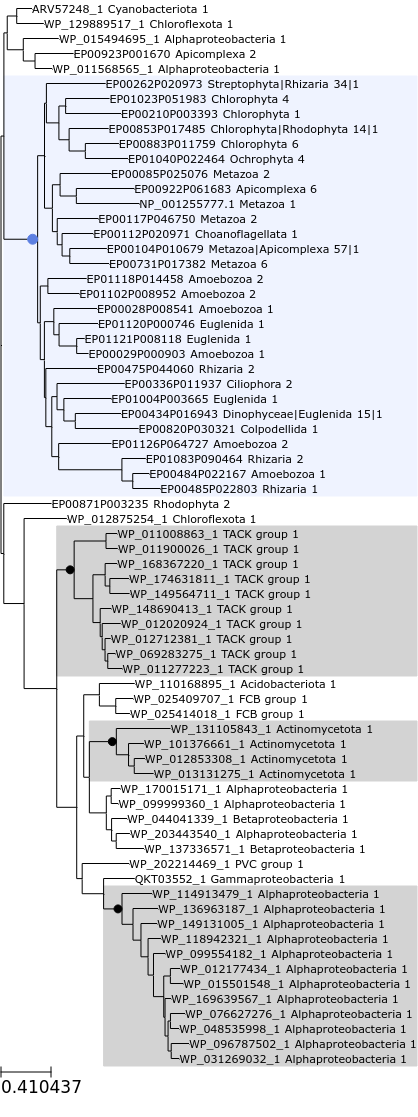

In [159]:
system_dl = next(systems_dl)
run_microcosms(system_dl, True)

{'K17285': 'methanethiol oxidase [EC:1.8.3.4]', 'K14829': 'pre-rRNA-processing protein IPI3', 'K07404': '6-phosphogluconolactonase [EC:3.1.1.31]', 'K12602': 'WD repeat-containing protein 61', 'K23325': 'transducin beta-like protein 2', 'K04508': 'transducin (beta)-like 1', 'K01045': 'arylesterase / paraoxonase [EC:3.1.1.2 3.1.8.1]', 'K12880': 'THO complex subunit 3', 'K14962': 'COMPASS component SWD2'}
System EP00850P010165 has Eukaryotic clades ['WP_215584454_1']
/data/tobiassonva/data/eukgen/processing/microcosm_minHGT/EP00850P010165/EP00850P010165.merged.fasta.muscle.treefile.annot
Tree has 28 leaves


alt.Chart(...)

Target Unnamed: 0   euk_clade_rep             euk_LCA  \
tree_name                                                               
EP00850P010165  K17285          1  WP_215584454_1  cellular organisms   
EP00850P010165  K17285          0  WP_215584454_1  cellular organisms   
EP00850P010165  K17285          3  WP_215584454_1  cellular organisms   
EP00850P010165  K17285          2  WP_215584454_1  cellular organisms   
EP00850P010165  K17285          4  WP_215584454_1  cellular organisms   
EP00850P010165  K17285          1  WP_215584454_1  cellular organisms   
EP00850P010165  K17285          0  WP_215584454_1  cellular organisms   
EP00850P010165  K17285          3  WP_215584454_1  cellular organisms   
EP00850P010165  K17285          2  WP_215584454_1  cellular organisms   
EP00850P010165  K17285          4  WP_215584454_1  cellular organisms   
EP00850P010165  K14829          1  WP_215584454_1  cellular organisms   
EP00850P010165  K14829          0  WP_215584454_1  cellular organisms   
EP00850P010165  K14829          3  WP_215584454_1  cellular organisms   
EP00850P010165  K14829          2  WP_215584454_1  cellular organisms   
EP00850P010165  K14829          4  WP_215584454_1  cellular organisms   
EP00850P010165  K07404          1  WP_215584454_1  cellular organisms   
EP00850P010165  K07404          0  WP_215584454_1  cellular organisms   
EP00850P010165  K07404          3  WP_215584454_1  cellular organisms   
EP00850P010165  K07404          2  WP_215584454_1  cellular organisms   
EP00850P010165  K07404          4  WP_215584454_1  cellular organisms   
EP00850P010165  K12602          1  WP_215584454_1  cellular organisms   
EP00850P010165  K12602          0  WP_215584454_1  cellular organisms   
EP00850P010165  K12602          3  WP_215584454_1  cellular organisms   
EP00850P010165  K12602          2  WP_215584454_1  cellular organisms   
EP00850P010165  K12602          4  WP_215584454_1  cellular organisms   
EP00850P010165  K23325          1  WP_215584454_1  cellular organisms   
EP00850P010165  K23325          0  WP_215584454_1  cellular organisms   
EP00850P010165  K23325          3  WP_215584454_1  cellular organisms   
EP00850P010165  K23325          2  WP_215584454_1  cellular organisms   
EP00850P010165  K23325          4  WP_215584454_1  cellular organisms   
EP00850P010165  K04508          1  WP_215584454_1  cellular organisms   
EP00850P010165  K04508          0  WP_215584454_1  cellular organisms   
EP00850P010165  K04508          3  WP_215584454_1  cellular organisms   
EP00850P010165  K04508          2  WP_215584454_1  cellular organisms   
EP00850P010165  K04508          4  WP_215584454_1  cellular organisms   
EP00850P010165  K01045          1  WP_215584454_1  cellular organisms   
EP00850P010165  K01045          1  WP_215584454_1  cellular organisms   
EP00850P010165  K12880          1  WP_215584454_1  cellular organisms   
EP00850P010165  K01045          0  WP_215584454_1  cellular organisms   
EP00850P010165  K01045          0  WP_215584454_1  cellular organisms   
EP00850P010165  K12880          0  WP_215584454_1  cellular organisms   
EP00850P010165  K01045          3  WP_215584454_1  cellular organisms   
EP00850P010165  K01045          3  WP_215584454_1  cellular organisms   
EP00850P010165  K12880          3  WP_215584454_1  cellular organisms   
EP00850P010165  K01045          2  WP_215584454_1  cellular organisms   
EP00850P010165  K01045          2  WP_215584454_1  cellular organisms   
EP00850P010165  K12880          2  WP_215584454_1  cellular organisms   
EP00850P010165  K01045          4  WP_215584454_1  cellular organisms   
EP00850P010165  K01045          4  WP_215584454_1  cellular organisms   
EP00850P010165  K12880          4  WP_215584454_1  cellular organisms   
EP00850P010165  K14962          1  WP_215584454_1  cellular organisms   
EP00850P010165  K14962          0  WP_215584454_1  cellular organisms   
EP00850P010165  K14962          3  WP_215584454_1  cellular organisms   
E

alt.VConcatChart(...)

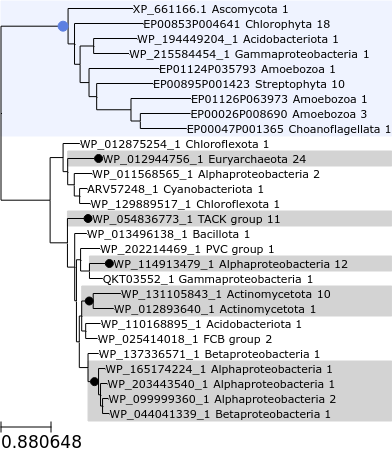

In [160]:
system = next(systems)
run_microcosms(system, False)

In [138]:
def run_microcosms(system, isdl):
    if isdl:
        microcosm_path = microcosm_dl_path
        data = tree_data_dl_mapped.loc[[system]].sort_values(by=['c-ELW'], ascending=False)
        print(data.description.unique())
        print(data.KOGS.unique())
    else:
        microcosm_path = microcosm_uc_path
        data = tree_data_mapped.loc[[system]].sort_values(by=['Score','c-ELW'], ascending=False)
        kogs, functions = data.Target, data.Description
        print(dict(zip(kogs, functions)))
        
    clades = data.euk_clade_rep.unique()
    print(f'System {system} has Eukaryotic clades {clades}')
    
    clade = clades[0]
    
    plot_data = data[data.euk_clade_rep == clade]
    
    dist_bar = alt.Chart(data, title=f'{system}: {clade}').mark_bar().encode(
        x = alt.X('prok_taxa', sort=None, axis=alt.Axis(labelAngle=-45)),
        y = alt.Y('top_dist'),
        color = alt.Color('prok_taxa:O'),
        tooltip = alt.Tooltip(['top_dist', 'prok_clade_weight', 'prok_clade_size', 'prok_clade_rep', 'prok_leaf_clade'])
    )
    
    print(f'{microcosm_path}{system}/{system}.merged.fasta.muscle.treefile.annot')
    tree = Tree(f'{microcosm_path}{system}/{system}.merged.fasta.muscle.treefile.annot')
    annot_tree, tree_img = color_tree(tree, view_in_notebook=True)
    
    
    from core_functions.altair_plots import plot_alignment
    aln_file = f'{microcosm_path}{system}/{system}.merged.fasta.muscle'
    
    #leaf_names = [leaf.name for leaf in trees[system].get_leaves()]
    leaf_names = [leaf.name for leaf in tree.get_leaves()]
    
    plot, aln_data = plot_alignment(aln_file, seqlimit=100, plot_range=(0,300), label_order=leaf_names)
    
    \
    print(f'Tree has {len(leaf_names)} leaves')
    display(dist_bar)
    display(data.drop(["euk_clade_size","euk_clade_weight","euk_leaf_clade","prok_clade_size","prok_clade_weight","prok_leaf_clade"], axis=1))#.iloc[:,[0,4,8,11,13,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]])
    #display(pd.DataFrame(CDD_annot.loc[system]))
    display(plot)
    display(tree_img)

In [ ]:
header_mapping_annot[header_mapping_annot.index.isin(['XP_031501475.1',
 'XP_002275543.1',
 'XP_012444669.1',
 'XP_012452889.1',
 'XP_026405603.1',
 'XP_026413187.1',
 'XP_002283744.2',
 'XP_006593399.1',
 'XP_012462945.1',
 'NP_175758.2',
 'XP_031500398.1',
 'PTQ49663.1',
 'XP_002108785.1',
 'XP_030844904.1',
 'XP_009051386.1',
 'XP_011405752.1',
 'XP_020048970.1',
 'XP_007709237.1',
 'XP_008908753.1',
 'OAC99004.1',
 'XP_664445.1',
 'KAA6408464.1',
 'XP_018192209.1'])]

# archive

### ribosomal analysis

In [ ]:
# ribosomal structural proteins
ribosome = pathway_data[pathway_data.CATEGORY_ID == "map03010"].KOGID
eukprofiles_ribosome = kegg_annot[kegg_annot.Target.isin(ribosome)]
microcosms_ribosome = tree_data_annot[tree_data_annot.tree_name.isin(eukprofiles_ribosome.Query)]
# ribosome biogenesis
ribosome_biogen = pathway_data[pathway_data.CATEGORY_ID == "map03008"].KOGID

which ribosome KOGs didn't find a microcosm


In [ ]:
hits_microcosms_ribosome = eukprofiles_ribosome[eukprofiles_ribosome.Query.isin(set(microcosms_ribosome.tree_name))]
KOGs_rib_inmicrocosms = set(hits_microcosms_ribosome.Target)
ribKOGs_notfound = set(ribosome).difference(KOGs_rib_inmicrocosms)
len(KOGs_rib_inmicrocosms), len(ribosome)

In [ ]:
# # ribosome KOGs that have no microcosms
#category_data[category_data.KOGID.isin(ribKOGs_notfound)].drop_duplicates("FUNCTION")

### translation factor analysis

In [ ]:
# translation_factors = set(initiation + elongation + release + prokaryotic_transfact)
# eukprofiles_transfac = kegg_annot[kegg_annot.Target.isin(translation_factors)]
# microcosms_transfac = tree_data_annot[tree_data_annot.tree_name.isin(eukprofiles_transfac.Query)]
# eukprofiles_transfac.shape[0], len(set(microcosms_transfac.tree_name))

### ribosome biogenesis analysis

In [ ]:
eukprofiles_rib_biogen = kegg_annot[kegg_annot.Target.isin(ribosome_biogen)]
microcosms_rib_biogen = tree_data_annot[tree_data_annot.tree_name.isin(eukprofiles_rib_biogen.Query)]
eukprofiles_rib_biogen.shape[0], len(set(microcosms_rib_biogen.tree_name))

### nuclear pore complex analysis

In [ ]:
# nuclear pore
nuclear_pore = pathway_data[pathway_data.CATEGORY_ID == "map03013"].KOGID
eukprofiles_nucpore = kegg_annot[kegg_annot.Target.isin(nuclear_pore)]
microcosms_nucpore = tree_data_annot[tree_data_annot.tree_name.isin(eukprofiles_nucpore.Query)]
eukprofiles_nucpore.shape[0], len(set(microcosms_nucpore.tree_name))

## everything else

In [ ]:
# ribosome
tree_data_filt = tree_data_mapped[tree_data_mapped["c-ELW"] > 0]
trees = tree_data_filt[tree_data_filt["Target"].isin(ribosome)]
trees_sorted = trees.sort_values(["Score", "c-ELW"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
systems = iter(trees_sorted.iloc[30:,:].tree_name)

In [ ]:
# nuclear pore
tree_data_tophit = tree_data_mapped.sort_values(["Score", "c-ELW"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_sorted = tree_data_tophit[tree_data_tophit["Target"].isin(nuclear_pore)]
systems = iter(trees_sorted[trees_sorted.Description.str.contains("Nup")].tree_name)


In [ ]:
# # release
# tree_data_tophit = tree_data_mapped.sort_values(["Score"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
# trees_sorted = tree_data_tophit[tree_data_tophit["Target"].isin(release)]
# systems = iter(trees_sorted.tree_name)


In [ ]:
# aa-tRNA biosynthesis
aa_trna = pathway_data[pathway_data.CATEGORY_ID == "map00970"].KOGID
eukprofiles_aatrna = kegg_annot[kegg_annot.Target.isin(aa_trna)]
microcosms_aatrna = tree_data_annot[tree_data_annot.tree_name.isin(eukprofiles_aatrna.Query)]
print(eukprofiles_aatrna.shape[0], len(set(microcosms_aatrna.tree_name)))
tree_data_tophit = tree_data_mapped.sort_values(["Score", "c-ELW"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_sorted = tree_data_tophit[tree_data_tophit["Target"].isin(aa_trna)]
trees_filtered = trees_sorted[trees_sorted["c-ELW"] > .5]
systems = iter(trees_filtered.tree_name)


In [ ]:
# mRNA surveillance 
mRNAsurv = pathway_data[pathway_data.CATEGORY_ID == "map03015"].KOGID
eukprofiles_msurv = kegg_annot[kegg_annot.Target.isin(mRNAsurv)]
microcosms_msurv = tree_data_annot[tree_data_annot.tree_name.isin(eukprofiles_msurv.Query)]
print(eukprofiles_msurv.shape[0], len(set(microcosms_msurv.tree_name)))
tree_data_tophit = tree_data_mapped.sort_values(["Score", "c-ELW"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_sorted = tree_data_tophit[tree_data_tophit["Target"].isin(mRNAsurv)]
trees_filtered = trees_sorted[trees_sorted["c-ELW"].between(.50,1)]
systems = iter(trees_filtered.tree_name)


In [ ]:
# ribosome biogenesis 
"map03008"
rBiogen = pathway_data[pathway_data.CATEGORY_ID == "map03008"].KOGID
eukprofiles_rbg = kegg_annot[kegg_annot.Target.isin(rBiogen)]
microcosms_rbg = tree_data_annot[tree_data_annot.tree_name.isin(eukprofiles_rbg.Query)]
print(eukprofiles_rbg.shape[0], len(set(microcosms_rbg.tree_name)))
tree_data_tophit = tree_data_mapped.sort_values(["Score", "c-ELW"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_sorted = tree_data_tophit[tree_data_tophit["Target"].isin(rBiogen)]
trees_filtered = trees_sorted[trees_sorted["c-ELW"].between(.501,.99)]
systems = iter(trees_sorted[70:].tree_name)


In [ ]:
# spliceosome 
"map03040"
splice = pathway_data[pathway_data.CATEGORY_ID == "map03040"].KOGID
tree_data_tophit = tree_data_mapped.sort_values(["Score", "c-ELW"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(splice)]
trees_filtered = tree_data_tophit[tree_data_tophit["Target"].isin(splice)]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.501,.99)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))

In [ ]:
# protein export
pe = pathway_data[pathway_data.CATEGORY_ID == "map03060"].KOGID
tree_data_tophit = tree_data_mapped.sort_values(["Score", "c-ELW"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(pe)]
trees_filtered = tree_data_tophit[tree_data_tophit["Target"].isin(pe)]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.501,.99)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))

In [ ]:
# ER, other (map04141)
er = set(pathway_data[pathway_data.CATEGORY_ID == "map04141"].KOGID).difference(set(pe))
tree_data_tophit = tree_data_mapped.sort_values(["Score", "c-ELW"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(er)]
trees_filtered = tree_data_tophit[tree_data_tophit["Target"].isin(er)]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.501,.99)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))

In [ ]:
#to do: save to file
erad = ["K14026", "K13993", "K03283", "K06689", "K13989", "K09562", "K09542", "K13525", "K09503", "K09502", "K10575",
"K03868","K04079","K04554","K14018","K09541","K09561","K09525"]

In [ ]:
copii = ["K14003", "K07953", "K14006", "K14007", "K14004", "K14005", "K14003"]
other_er = set(trees_filtered.Target).difference(set(erad + copii))

In [ ]:
# endocytosis
endo = set(pathway_data[pathway_data.CATEGORY_ID == "map04144"].KOGID).difference(set(pe))
tree_data_tophit = tree_data_mapped.sort_values(["Score", "c-ELW"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(endo)]
trees_filtered = tree_data_tophit[tree_data_tophit["Target"].isin(endo)]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.501,.99)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))

In [ ]:
# SNARE interactions in vesicular transport
snare = set(pathway_data[pathway_data.CATEGORY_ID == "map04130"].KOGID).difference(set(pe))
tree_data_tophit = tree_data_mapped.sort_values(["Score", "c-ELW"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(snare)]
trees_filtered = tree_data_tophit[tree_data_tophit["Target"].isin(snare)]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.501,.99)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))

In [ ]:
# Ubiquitin mediated proteolysis
ump = set(pathway_data[pathway_data.CATEGORY_ID == "map04120"].KOGID).difference(set(pe))
tree_data_tophit = tree_data_mapped.sort_values(["Score", "c-ELW"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(ump)]
trees_filtered = tree_data_tophit[tree_data_tophit["Target"].isin(ump)]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.501,.99)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))

In [ ]:
# Sulfur transfer
sutr = set(pathway_data[pathway_data.CATEGORY_ID == "map04122"].KOGID).difference(set(pe))
tree_data_tophit = tree_data_mapped.sort_values(["Score", "c-ELW"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(sutr)]
trees_filtered = tree_data_tophit[tree_data_tophit["Target"].isin(sutr)]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.501,.99)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))

In [ ]:
# proteosome
prsm = set(pathway_data[pathway_data.CATEGORY_ID == "map03050"].KOGID).difference(set(pe))
tree_data_tophit = tree_data_mapped.sort_values(["Score", "c-ELW"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(prsm)]
trees_filtered = tree_data_tophit[tree_data_tophit["Target"].isin(prsm)]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.501,.99)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))

In [ ]:
# rna degradation
rnad = set(pathway_data[pathway_data.CATEGORY_ID == "map03018"].KOGID)#.difference(set(pe))
tree_data_tophit = tree_data_mapped.sort_values(["Score", "c-ELW"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(rnad)]
trees_filtered = tree_data_tophit[tree_data_tophit["Target"].isin(rnad)]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.501,.99)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))


In [ ]:
# dna replication
dnar = set(pathway_data[pathway_data.CATEGORY_ID == "map03030"].KOGID)
tree_data_tophit = tree_data_mapped.reset_index().sort_values(["Score", "c-ELW"], ascending = False).drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(dnar)]
trees_filtered = tree_data_tophit[tree_data_tophit["Target"].isin(dnar)]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.5,1)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))


In [ ]:
# base excision repair
bexr = set(pathway_data[pathway_data.CATEGORY_ID == "map03410"].KOGID).difference(dnar)
tree_data_tophit = tree_data_mapped.reset_index().sort_values(["Score", "c-ELW"], ascending = False).drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(bexr)]
trees_filtered = tree_data_tophit[tree_data_tophit["Target"].isin(bexr)]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.5,1)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))


In [ ]:
# nucleotide excision repair
nexr = set(pathway_data[pathway_data.CATEGORY_ID == "map03420"].KOGID).difference(dnar)
tree_data_tophit = tree_data_mapped.reset_index().sort_values(["Score", "c-ELW"], ascending = False).drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(nexr)]
trees_filtered = tree_data_tophit[(tree_data_tophit["Target"].isin(nexr)) & ~(tree_data_tophit["Description"].str.contains("DNA-directed RNA polymerase"))]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.5,1)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))


In [ ]:
# mismatch repair
mmr = set(pathway_data[pathway_data.CATEGORY_ID == "map03430"].KOGID).difference(dnar)
tree_data_tophit = tree_data_mapped.reset_index().sort_values(["Score", "c-ELW"], ascending = False).drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(mmr)]
trees_filtered = tree_data_tophit[(tree_data_tophit["Target"].isin(mmr))]# & ~(tree_data_tophit["Description"].str.contains("DNA-directed RNA polymerase"))]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.5,1)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))


In [ ]:
# homologous recombination
hr = set(pathway_data[pathway_data.CATEGORY_ID == "map03440"].KOGID).difference(dnar)
tree_data_tophit = tree_data_mapped.reset_index().sort_values(["Score", "c-ELW"], ascending = False).drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(hr)]
trees_filtered = tree_data_tophit[(tree_data_tophit["Target"].isin(hr))]# & ~(tree_data_tophit["Description"].str.contains("DNA-directed RNA polymerase"))]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.5,1)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))


In [ ]:
### NHEJ
nhej = set(pathway_data[pathway_data.CATEGORY_ID == "map03450"].KOGID).difference(dnar)
tree_data_tophit = tree_data_mapped.reset_index().sort_values(["Score", "c-ELW"], ascending = False).drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(nhej)]
trees_filtered = tree_data_tophit[(tree_data_tophit["Target"].isin(nhej))]# & ~(tree_data_tophit["Description"].str.contains("DNA-directed RNA polymerase"))]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.5,1)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))


In [ ]:
### fanconi anemia
fanc = set(pathway_data[pathway_data.CATEGORY_ID == "map03460"].KOGID).difference(dnar.union(hr).union(nexr).union(mmr))
tree_data_tophit = tree_data_mapped.reset_index().sort_values(["Score", "c-ELW"], ascending = False).drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(fanc)]
trees_filtered = tree_data_tophit[(tree_data_tophit["Target"].isin(fanc))]# & ~(tree_data_tophit["Description"].str.contains("DNA-directed RNA polymerase"))]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.5,1)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))


In [ ]:
# RNA polymerase
rnap = set(pathway_data[pathway_data.CATEGORY_ID == "map03020"].KOGID)#.KOGID).difference(dnar.union(hr).union(nexr).union(mmr))
tree_data_tophit = tree_data_mapped.reset_index().sort_values(["Score", "c-ELW"], ascending = False).drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(rnap)]
trees_filtered = tree_data_tophit[(tree_data_tophit["Target"].isin(rnap))]# & ~(tree_data_tophit["Description"].str.contains("DNA-directed RNA polymerase"))]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.5,1)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))


In [ ]:
# basal transcription factors
filtered_batf = """
K03142
K03120
K03124
K03130
K03144
""".split("\n")
batf = set(pathway_data[pathway_data.CATEGORY_ID == "map03022"].KOGID)#.difference(nexr)
tree_data_tophit = tree_data_mapped.reset_index().sort_values(["Score", "c-ELW"], ascending = False).drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(batf)]
trees_filtered = tree_data_tophit[(tree_data_tophit["Target"].isin(filtered_batf))]# & ~(tree_data_tophit["Description"].str.contains("DNA-directed RNA polymerase"))]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.5,1)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))


In [ ]:
# transcription, other
transcription_kogs = set(kog2brite[kog2brite.brite == "03021"].ENTRY)
trans_other = transcription_kogs.difference(rnap.union(batf))
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(trans_other)]
trees_filtered = tree_data_tophit[(tree_data_tophit["Target"].isin(trans_other))]# & ~(tree_data_tophit["Description"].str.contains("DNA-directed RNA polymerase"))]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.5,1)]
systems = iter(trees_cELW.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))


In [ ]:
# transporters, other
transp_other = set(kog_brite[(kog_brite.brite_C.str.contains("02000")) & ~(kog_brite.kogid.isin(kogs_w_pathway))].kogid)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(transp_other)]
trees_filtered = tree_data_universal[(tree_data_universal["Target"].isin(transp_other))]# & ~(tree_data_tophit["Description"].str.contains("DNA-directed RNA polymerase"))]
trees_cELW = trees_filtered[trees_filtered["c-ELW"].between(.5,1)]
systems = iter(trees_cELW.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))


### filter pathways and look at top sister clades

In [ ]:
# number of microcosms with this pathway
len(set(trees_filtered.index))


In [ ]:
# all sister clades
trees_filtered.sort_values("c-ELW", ascending = False).drop_duplicates("euk_clade_rep")["prok_taxa"].value_counts()

In [ ]:
# all sister clades with high c-ELW
trees_sorted[trees_sorted["c-ELW"].between(.5,.999)].sort_values("c-ELW", ascending = False).drop_duplicates("euk_clade_rep")["prok_taxa"].value_counts()

In [ ]:
ribosome_lsu = ['K02925',
'K02930',
'K02932',
'K02934',
'K02937',
'K02936',
'K02938',
'K02940',
'K02866',
'K02865',
'K02868',
'K02870',
'K02873',
'K02872',
'K02875',
'K02877',
'K02880',
'K02883',
'K02882',
'K02885',
'K02889',
'K02891',
'K02894',
'K02893',
'K02896',
'K02898',
'K02901',
'K02900',
'K02903',
'K02905',
'K02908',
'K02910',
'K02912',
'K02915',
'K02918',
'K02917',
'K02920',
'K02922',
'K02921',
'K02923',
'K02924',
'K02927',
'K02928',
'K02929',
'K02941',
'K02942',
'K02943']

initiation = """K02519
K02520
K03113
K03236
K03237
K03238
K03239
K03240
K03241
K03242
K03243
K03245
K03246
K03247
K03248
K03249
K03250
K03251
K03252
K03253
K03254
K03255
K03257
K03258
K03259
K03260
K03261
K03262
K03263
K03264
K03680
K03754
K06158
K06184
K13025
K15026
K15027
K15028
K15029
K15030
K15908
K18995
K19036
K23325
K24086""".split("\n")
elongation = """K00586
K02355
K02357
K02358
K03231
K03232
K03233
K03234
K03235
K03833
K06927
K07561
K15410
K15455
K17866
K17867
K17868
K17878
K19539
K21803
K22696
K22855
K22856
K22857
K24887
K25166""".split("\n")
release = """K03265
K03267
K15031
K15033
K02835
K02838
K02493
K19589
K15448
K01056
K04794""".split("\n")

prokaryotic_transfact = """K01056
K02355
K02356
K02357
K02358
K02493
K02518
K02519
K02520
K02835
K02836
K02837
K02838
K02839
K03833
K04568
K04794
K09890
K09906
K15034
K19810""".split("\n")

In [ ]:
set(prokaryotic_transfact).difference(set(initiation + elongation + release))

In [ ]:
len(prokaryotic_transfact)